# Cross-Dataset Validation: FoR → In-the-Wild

This notebook evaluates the generalization capability of audio deepfake detection models trained on the FoR (Fake or Real) dataset when tested on the In-the-Wild dataset.

**Objective**: Assess how well models trained on controlled/synthetic data generalize to real-world deepfake audio samples.

## Dataset Overview
- **Training Dataset**: FoR (Fake or Real) - controlled dataset with known TTS systems
- **Test Dataset**: In-the-Wild - real-world deepfake audio collected from various sources

In [1]:
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve, 
    auc,
)
import warnings
warnings.filterwarnings('ignore')

from utils.utils import train_and_evaluate_linear_svm

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

## 1. Configuration and Paths

In [3]:
FOR_FEATURES_DIR = PROJECT_ROOT / "FoR_dataset" / "features"
ITW_DATASET_DIR = PROJECT_ROOT / "in-the-wild-audio-deepfake" / "release_in_the_wild"
ITW_NORMALIZED_DATASET_DIR = PROJECT_ROOT / "in-the-wild-audio-deepfake" / "release_in_the_wild_normalized"
ITW_META_PATH = PROJECT_ROOT / "in-the-wild-audio-deepfake" / "modified_meta.csv"
ITW_FEATURES_DIR = PROJECT_ROOT / "in-the-wild-audio-deepfake" / "features"
ITW_NORMALIZED_FEATURES_DIR = PROJECT_ROOT / "in-the-wild-audio-deepfake" / "normalized_features"
ITW_FEATURES = ITW_FEATURES_DIR / "itw_features_40_2048_512_128.parquet"
ITW_NORMALIZED_FEATURES = ITW_NORMALIZED_FEATURES_DIR / "itw_features_40_2048_512_128_loudness_normalized.parquet"


print(f"FoR Features Directory: {FOR_FEATURES_DIR}")
print(f"In-the-Wild Dataset Directory: {ITW_DATASET_DIR}")
print(f"In-the-Wild Metadata: {ITW_META_PATH}")

FoR Features Directory: /home/automaton/MSc/audio-deepfake-detection/FoR_dataset/features
In-the-Wild Dataset Directory: /home/automaton/MSc/audio-deepfake-detection/in-the-wild-audio-deepfake/release_in_the_wild
In-the-Wild Metadata: /home/automaton/MSc/audio-deepfake-detection/in-the-wild-audio-deepfake/modified_meta.csv


## 2. Load FoR Training Data

In [10]:
train_df = pd.read_parquet(FOR_FEATURES_DIR / "training_features_40_2048_512_128.parquet")
train_df.dropna(inplace=True)

print(f"FoR Training samples: {len(train_df)}")
print(f"Features: {train_df.shape[1] - 2}")
print(f"\nLabel distribution:")
print(train_df['label'].value_counts())

FoR Training samples: 53854
Features: 510

Label distribution:
label
real    26932
fake    26922
Name: count, dtype: int64


In [11]:
X_train = train_df.drop(columns=["label", "filename"])
y_train = train_df["label"].map({"real": 0, "fake": 1})

print(f"X_train shape: {X_train.shape}")
print(f"y_train distribution: {y_train.value_counts().to_dict()}")

X_train shape: (53854, 510)
y_train distribution: {0: 26932, 1: 26922}


## 3. Extract Features from In-the-Wild Dataset

We need to extract the same features from the In-the-Wild dataset that were used for the FoR dataset.

In [8]:
ITW_FEATURES_PATH.parent.mkdir(parents=True, exist_ok=True)

if ITW_FEATURES_PATH.exists():
    print(f"Loading cached features from {ITW_FEATURES_PATH}")
    itw_df = pd.read_parquet(ITW_FEATURES_PATH)
    print(f"Loaded {len(itw_df)} samples")
else:
    print("Features not found. Will extract in next cell.")
    itw_df = None

Loading cached features from /home/automaton/MSc/audio-deepfake-detection/in-the-wild-audio-deepfake/features/itw_features_40_2048_512_128.parquet
Loaded 31779 samples


In [7]:
if itw_df is None:
    from data_preprocessing.feature_extraction import extract_features_from_folder
    
    N_MFCC = 40
    N_FFT = 2048
    HOP_LENGTH = 512
    N_MELS = 128
    
    feature_config = {
        "rmse": {},
        "zero_crossing_rate": {},
        "spectral_centroid": {},
        "spectral_bandwidth": {},
        "spectral_flatness": {},
        "spectral_rolloff": {},
        "mfcc": {"n_mfcc": N_MFCC, "n_fft": N_FFT, "hop_length": HOP_LENGTH},
        "mfcc_delta": {"n_mfcc": N_MFCC, "n_fft": N_FFT, "hop_length": HOP_LENGTH},
        "mfcc_delta2": {"n_mfcc": N_MFCC, "n_fft": N_FFT, "hop_length": HOP_LENGTH},
        "pitch_yin": {"fmin": 50, "fmax": 300},
        "mel_spectrogram": {"n_mels": N_MELS},
    }
    
    print("Extracting features from In-the-Wild dataset...")
    print(f"Dataset path: {ITW_DATASET_DIR}")
    
    itw_df = extract_features_from_folder(
        folder_path=str(ITW_DATASET_DIR),
        feature_config=feature_config,
        sample_rate=16000,
        num_workers=None
    )
    
    itw_df.to_parquet(ITW_FEATURES_PATH, index=False)
    print(f"Saved features to {ITW_FEATURES_PATH}")

Extracting features from In-the-Wild dataset...
Dataset path: /home/automaton/MSc/audio-deepfake-detection/in-the-wild-audio-deepfake/release_in_the_wild
Using 15 workers...


Extracting features: 100%|██████████| 31779/31779 [29:26<00:00, 17.99it/s]


Saved features to /home/automaton/MSc/audio-deepfake-detection/in-the-wild-audio-deepfake/features/itw_features_40_2048_512_128.parquet


In [9]:
print(f"In-the-Wild samples: {len(itw_df)}")
print(f"Features: {itw_df.shape[1] - 2}")
print(f"\nLabel distribution:")
print(itw_df['label'].value_counts())
print(f"\nMissing values: {itw_df.isna().sum().max()}")

In-the-Wild samples: 31779
Features: 510

Label distribution:
label
real    19963
fake    11816
Name: count, dtype: int64

Missing values: 0


In [10]:
itw_df_clean = itw_df.dropna()
print(f"Samples after dropping NaN: {len(itw_df_clean)} (dropped {len(itw_df) - len(itw_df_clean)})")

X_test_itw = itw_df_clean.drop(columns=["label", "filename"])
y_test_itw = itw_df_clean["label"].map({"real": 0, "fake": 1})

print(f"\nX_test_itw shape: {X_test_itw.shape}")
print(f"y_test_itw distribution: {y_test_itw.value_counts().to_dict()}")

Samples after dropping NaN: 31779 (dropped 0)

X_test_itw shape: (31779, 510)
y_test_itw distribution: {0: 19963, 1: 11816}


## 4. Feature Alignment Check

Ensure both datasets have the same features in the same order.

In [11]:
train_features = set(X_train.columns)
test_features = set(X_test_itw.columns)

missing_in_test = train_features - test_features
extra_in_test = test_features - train_features

print(f"Features in training set: {len(train_features)}")
print(f"Features in test set: {len(test_features)}")
print(f"Missing in test: {missing_in_test}")
print(f"Extra in test: {extra_in_test}")

common_features = list(train_features & test_features)
X_train_aligned = X_train[common_features]
X_test_aligned = X_test_itw[common_features]

print(f"\nAligned feature count: {len(common_features)}")

Features in training set: 510
Features in test set: 510
Missing in test: set()
Extra in test: set()

Aligned feature count: 510


## 5. Train Models on FoR Dataset

In [ ]:
print("Note: The Linear SVM pipeline includes StandardScaler internally.")
print(f"X_train_aligned shape: {X_train_aligned.shape}")
print(f"X_test_aligned shape: {X_test_aligned.shape}")

Note: The Linear SVM pipeline includes StandardScaler internally.
X_train_aligned shape: (53854, 510)
X_test_aligned shape: (31779, 510)


In [13]:
svc_params = {
    "C": 100,
    "class_weight": "balanced",
    "max_iter": 20000,
    "random_state": 42
}

train_path = str(FOR_FEATURES_DIR / "training_features_40_2048_512_128.parquet")
test_path = str(FOR_FEATURES_DIR / "testing_features_40_2048_512_128.parquet")

print("Training Linear SVM on FoR dataset...")
pipeline, for_metrics, _, feature_names, metadata_extra = train_and_evaluate_linear_svm(
    train_path, test_path, svc_params
)

print(f"\nFoR Test Set Metrics:")
for k, v in for_metrics.items():
    print(f"  {k}: {v:.4f}")

Training Linear SVM on FoR dataset...

FoR Test Set Metrics:
  accuracy: 0.8356
  precision: 0.8736
  recall: 0.7932
  f1: 0.8355
  roc_auc: 0.8366


In [14]:
trained_models = {"Linear SVM": pipeline}
print("Linear SVM model ready for cross-dataset evaluation!")

Linear SVM model ready for cross-dataset evaluation!


## 6. Evaluate on In-the-Wild Dataset (Cross-Dataset Validation)

In [23]:
train_data_path = os.path.join(FOR_FEATURES_DIR, "training_features_40_2048_512_128.parquet")
test_data_path = os.path.join(ITW_FEATURES_PATH)

df = pd.read_parquet(train_data_path)
df_test = pd.read_parquet(test_data_path)
#print(df.head())
print(df_test.head())
print(df_test.shape)
#df.shape()

svc_params = {
            "C": 100,
            "class_weight": "balanced",
            "max_iter": 20000,
            "random_state": 42
        }
pipeline, metrics, svc_params, feature_names, metadata_extra = train_and_evaluate_linear_svm(train_data_path, test_data_path, svc_params)

  label   filename  mfcc_mean_0  mfcc_std_0  mfcc_mean_1  mfcc_std_1  \
0  real  28223.wav  -177.225708  103.921265    69.349701   57.308010   
1  real   9552.wav  -242.643433   52.204433    97.979523   20.055964   
2  real  16045.wav  -415.618896   76.725121   105.148087   38.864712   
3  real  29273.wav  -248.436340   89.143135    88.062119   49.298008   
4  real  15656.wav  -332.988190   68.098282   181.467178   53.083740   

   mfcc_mean_2  mfcc_std_2  mfcc_mean_3  mfcc_std_3  ...  \
0    10.161529   32.963696    46.647041   22.054977  ...   
1    13.162400   14.935350    29.829882   14.303648  ...   
2    14.319618   17.834265    15.644127   10.947448  ...   
3   -18.347378   46.240593    18.859877   29.578329  ...   
4    16.821630   23.020903    16.203640   24.552652  ...   

   mel_spectrogram_mean_123  mel_spectrogram_std_123  \
0                  0.200127                 0.919803   
1                  0.000262                 0.000128   
2                  0.000264           

In [ ]:
print(metrics)

{'accuracy': 0.6641178136505239, 'precision': 0.835093896713615, 'recall': 0.12042992552471225, 'f1': 0.49859254008373755, 'roc_auc': 0.5531769424247316}


## 7. Results Summary

In [25]:
print("Cross-Dataset Validation Results (FoR → In-the-Wild)")
print("="*60)
print(f"Model: Linear SVM")
print(f"Accuracy:  {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1 Score:  {metrics['f1']:.4f}")
print(f"AUC-ROC:   {metrics['roc_auc']:.4f}")

Cross-Dataset Validation Results (FoR → In-the-Wild)
Model: Linear SVM
Accuracy:  0.6641
Precision: 0.8351
Recall:    0.1204
F1 Score:  0.4986
AUC-ROC:   0.5532


## 8. Visualizations

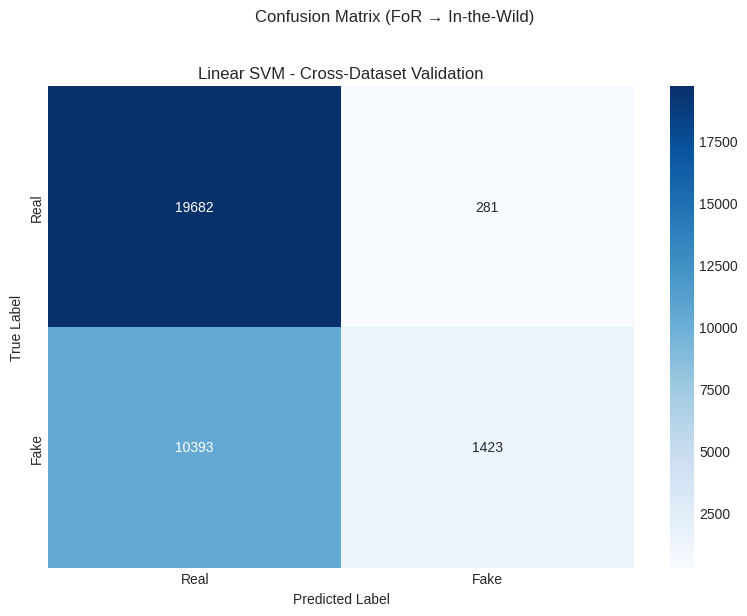

In [26]:
itw_test_df = pd.read_parquet(ITW_FEATURES_PATH)
itw_test_df.dropna(inplace=True)
X_itw = itw_test_df.drop(columns=["label", "filename"], errors="ignore")
y_itw = itw_test_df["label"].map({"real": 0, "fake": 1}).values

y_pred_itw = pipeline.predict(X_itw)
y_scores_itw = pipeline.decision_function(X_itw)

fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_itw, y_pred_itw)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Real', 'Fake'],
    yticklabels=['Real', 'Fake'],
    ax=ax
)
ax.set_title("Linear SVM - Cross-Dataset Validation")
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

plt.suptitle('Confusion Matrix (FoR → In-the-Wild)', y=1.02)
plt.tight_layout()
plt.show()

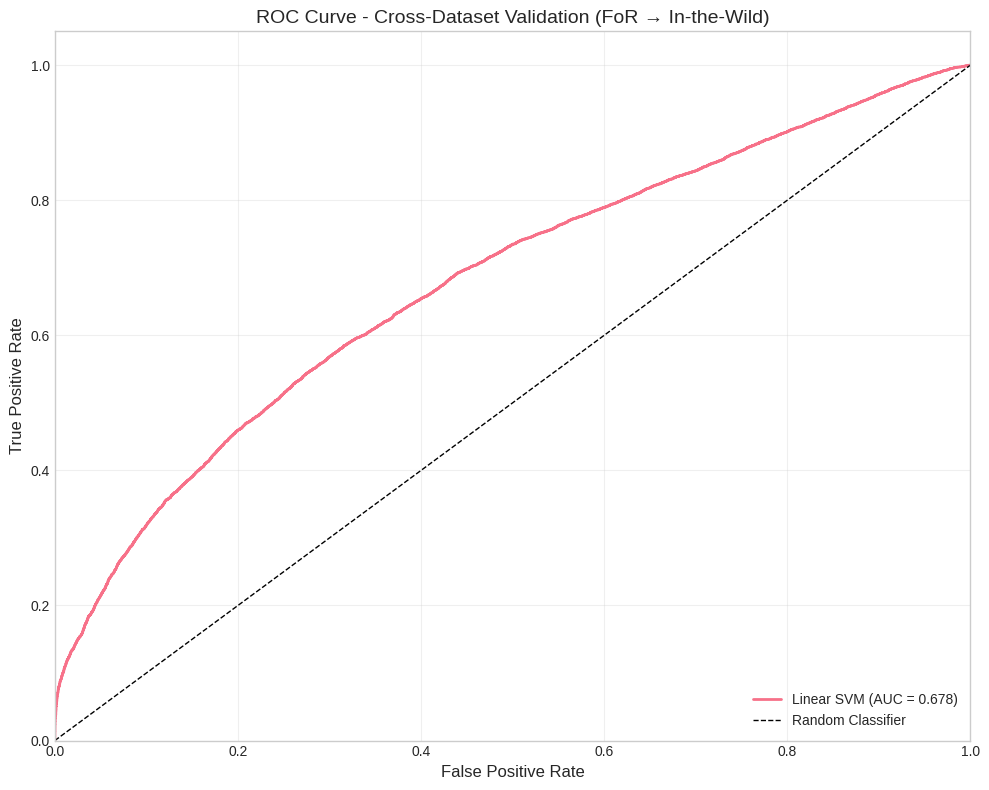

In [27]:
fpr_itw, tpr_itw, _ = roc_curve(y_itw, y_scores_itw)
roc_auc_itw = auc(fpr_itw, tpr_itw)

plt.figure(figsize=(10, 8))
plt.plot(fpr_itw, tpr_itw, label=f"Linear SVM (AUC = {roc_auc_itw:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Cross-Dataset Validation (FoR → In-the-Wild)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

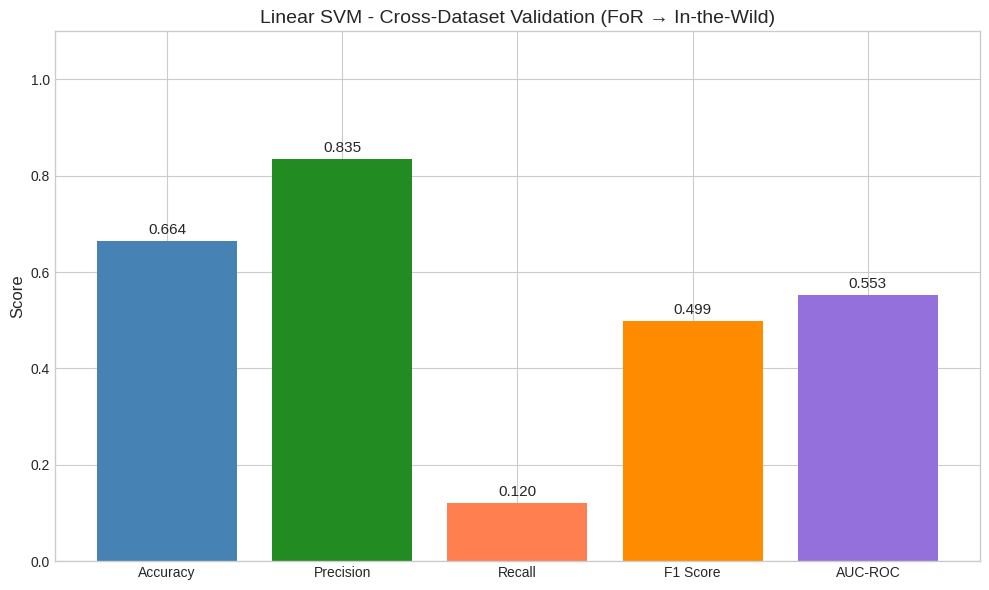

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1'], metrics['roc_auc']]
colors = ['steelblue', 'forestgreen', 'coral', 'darkorange', 'mediumpurple']

bars = ax.bar(metric_names, values, color=colors)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Linear SVM - Cross-Dataset Validation (FoR → In-the-Wild)', fontsize=14)
ax.set_ylim([0, 1.1])

for bar, val in zip(bars, values):
    ax.annotate(f'{val:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

## 9. Baseline Comparison: Same-Dataset Performance

Compare cross-dataset performance with same-dataset (FoR test set) performance.

In [29]:
for_test_path = FOR_FEATURES_DIR / "testing_features_40_2048_512_128.parquet"

if for_test_path.exists():
    test_for_df = pd.read_parquet(for_test_path)
    test_for_df.dropna(inplace=True)
    
    X_test_for = test_for_df.drop(columns=["label", "filename"])[common_features]
    y_test_for = test_for_df["label"].map({"real": 0, "fake": 1})
    
    print(f"FoR Test samples: {len(test_for_df)}")
    print(f"Label distribution: {y_test_for.value_counts().to_dict()}")
else:
    print("FoR test features not found")
    X_test_for = None

FoR Test samples: 4634
Label distribution: {1: 2370, 0: 2264}


## 10. Error Analysis

In [32]:
error_df = itw_df_clean.copy()
error_df['predicted'] = y_pred_itw
error_df['true_label'] = y_itw
error_df['correct'] = error_df['predicted'] == error_df['true_label']
error_df['score'] = y_scores_itw

print(f"Model: Linear SVM")
print(f"\nCorrect predictions: {error_df['correct'].sum()} ({error_df['correct'].mean()*100:.2f}%)")
print(f"Incorrect predictions: {(~error_df['correct']).sum()} ({(~error_df['correct']).mean()*100:.2f}%)")

Model: Linear SVM

Correct predictions: 21105 (66.41%)
Incorrect predictions: 10674 (33.59%)


In [33]:
false_positives = error_df[(error_df['true_label'] == 0) & (error_df['predicted'] == 1)]
false_negatives = error_df[(error_df['true_label'] == 1) & (error_df['predicted'] == 0)]

print(f"False Positives (Real predicted as Fake): {len(false_positives)}")
print(f"False Negatives (Fake predicted as Real): {len(false_negatives)}")

print(f"\nTop False Positives (highest score):")
print(false_positives.nlargest(5, 'score')[['filename', 'score']].to_string(index=False))

print(f"\nTop False Negatives (lowest score):")
print(false_negatives.nsmallest(5, 'score')[['filename', 'score']].to_string(index=False))

False Positives (Real predicted as Fake): 281
False Negatives (Fake predicted as Real): 10393

Top False Positives (highest score):
 filename    score
25002.wav 9.475567
 6483.wav 5.421089
10117.wav 5.017521
18462.wav 2.690320
10067.wav 2.442497

Top False Negatives (lowest score):
 filename      score
30964.wav -12.189668
27966.wav -11.358318
 2356.wav  -9.583884
24750.wav  -9.300607
 2203.wav  -7.851718


## 11. Re-extract features fot Loudness Normalized In-The-Wild Dataset

In [4]:
if ITW_NORMALIZED_FEATURES_DIR.exists() and ITW_NORMALIZED_FEATURES.exists():
    print(f"Loading cached features from {ITW_NORMALIZED_FEATURES}")
    itw_df_normalized = pd.read_parquet(ITW_NORMALIZED_FEATURES)
    print(f"Loaded {len(itw_df_normalized)} samples")
else:
    if not ITW_NORMALIZED_FEATURES_DIR.exists():
        print(f"Creating directory {ITW_NORMALIZED_FEATURES_DIR}")
        ITW_NORMALIZED_FEATURES_DIR.mkdir(parents=True, exist_ok=True)
    if not ITW_NORMALIZED_FEATURES.exists():
        print(f"Features not found. Will extract in next cell.")
        itw_df_normalized = None

Features not found. Will extract in next cell.


In [8]:
if itw_df_normalized is None and not ITW_NORMALIZED_FEATURES.exists():
    from data_preprocessing.feature_extraction import extract_features_from_folder
    
    N_MFCC = 40
    N_FFT = 2048
    HOP_LENGTH = 512
    N_MELS = 128
    
    feature_config = {
        "rmse": {},
        "zero_crossing_rate": {},
        "spectral_centroid": {},
        "spectral_bandwidth": {},
        "spectral_flatness": {},
        "spectral_rolloff": {},
        "mfcc": {"n_mfcc": N_MFCC, "n_fft": N_FFT, "hop_length": HOP_LENGTH},
        "mfcc_delta": {"n_mfcc": N_MFCC, "n_fft": N_FFT, "hop_length": HOP_LENGTH},
        "mfcc_delta2": {"n_mfcc": N_MFCC, "n_fft": N_FFT, "hop_length": HOP_LENGTH},
        "pitch_yin": {"fmin": 50, "fmax": 300},
        "mel_spectrogram": {"n_mels": N_MELS},
    }
    
    print("Extracting features from In-the-Wild dataset...")
    print(f"Dataset path: {ITW_NORMALIZED_DATASET_DIR}")
    
    itw_df_normalized = extract_features_from_folder(
        folder_path=str(ITW_NORMALIZED_DATASET_DIR),
        feature_config=feature_config,
        sample_rate=16000,
        num_workers=None
    )
    
    itw_df_normalized.to_parquet(ITW_NORMALIZED_FEATURES, index=False)
    print(f"Saved features to {ITW_NORMALIZED_FEATURES}")
else:
    print(f"Loading cached features from {ITW_NORMALIZED_FEATURES}")
    itw_df_normalized = pd.read_parquet(ITW_NORMALIZED_FEATURES)
    print(f"Loaded {len(itw_df_normalized)} samples")


Extracting features from In-the-Wild dataset...
Dataset path: /home/automaton/MSc/audio-deepfake-detection/in-the-wild-audio-deepfake/release_in_the_wild_normalized
Using 21 workers...


Extracting features: 100%|██████████| 31779/31779 [30:15<00:00, 17.51it/s]  


Saved features to /home/automaton/MSc/audio-deepfake-detection/in-the-wild-audio-deepfake/normalized_features/itw_features_40_2048_512_128_loudness_normalized.parquet


In [ ]:
itw_df_normalized_clean = itw_df_normalized.dropna()
print(f"Samples after dropping NaN: {len(itw_df_normalized_clean)} (dropped {len(itw_df_normalized) - len(itw_df_normalized_clean)})")

X_test_itw_normalized = itw_df_normalized_clean.drop(columns=["label", "filename"])
y_test_itw_normalized = itw_df_normalized_clean["label"].map({"real": 0, "fake": 1})

print(f"\nX_test_itw_normalized shape: {X_test_itw_normalized.shape}")
print(f"y_test_itw_normalized distribution: {y_test_itw_normalized.value_counts().to_dict()}")

Samples after dropping NaN: 31779 (dropped 0)


NameError: name 'itw_df_clean' is not defined

In [12]:
train_features = set(X_train.columns)
test_features = set(X_test_itw.columns)

missing_in_test = train_features - test_features
extra_in_test = test_features - train_features

print(f"Features in training set: {len(train_features)}")
print(f"Features in test set: {len(test_features)}")
print(f"Missing in test: {missing_in_test}")
print(f"Extra in test: {extra_in_test}")

common_features = list(train_features & test_features)
X_train_aligned = X_train[common_features]
X_test_aligned = X_test_itw[common_features]

print(f"\nAligned feature count: {len(common_features)}")

NameError: name 'X_test_itw' is not defined